In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("BTC.csv")
data_list = data['close_price'].to_list()

In [4]:
def normalize(series):
    s = np.array(series)
    min_val = s.min()
    max_val = s.max()
    normalized = (s - min_val) / (max_val - min_val)
    return normalized

def denormalize(norm_series, min_val, max_val):
    return norm_series * (max_val - min_val) + min_val


In [5]:
real_data = normalize(data_list[100:115])
print(real_data)

[0.71651701 1.         0.86138526 0.64700365 0.46622549 0.69950376
 0.35176404 0.418673   0.28528915 0.4403396  0.11500587 0.13318889
 0.         0.28661343 0.03470334]


In [5]:
def forecast_log_trend(data, steps=15, window=10):
    y = np.log(data[-window:])
    x = np.arange(window)
    slope, intercept = np.polyfit(x, y, 1)

    forecast_x = np.arange(window, window + steps)
    forecast_log = slope * forecast_x + intercept
    return np.exp(forecast_log).tolist()

forecast_log_data = normalize(forecast_log_trend(data_list[:50]))
print(forecast_log_data)

[1.         0.9283899  0.85680778 0.78525361 0.71372739 0.64222911
 0.57075876 0.49931633 0.42790179 0.35651516 0.2851564  0.21382552
 0.1425225  0.07124733 0.        ]


In [6]:
def forecast_bollinger(data, window=20, steps=15):
    sma = np.mean(data[-window:])
    std = np.std(data[-window:])
    last = data[-1]
    forecast = []
    for i in range(steps):
        pull_strength = 0.4 * np.exp(-i / 5)  # exponential decay
        next_val = last + pull_strength * (sma - last)
        forecast.append(next_val)
        last = next_val
    return forecast


forecast_bb_data = normalize(forecast_bollinger(data_list[:50]))
print(forecast_bb_data)

[0.         0.38566081 0.59800671 0.72524567 0.80655125 0.86115438
 0.89928118 0.92673598 0.94699686 0.96224542 0.97390442 0.98293326
 0.98999782 0.99557191 1.        ]


In [7]:
def forecast_fourier(data, steps=15, n_terms=5):
    N = len(data)
    t = np.arange(N)
    f = np.fft.fft(data)
    freqs = np.fft.fftfreq(N)
    
    indexes = np.argsort(np.abs(f))[-n_terms:]
    forecast_t = np.arange(N, N + steps)
    
    result = np.zeros(steps)
    for i in indexes:
        amp = np.abs(f[i]) / N
        phase = np.angle(f[i])
        freq = freqs[i]
        result += amp * np.cos(2 * np.pi * freq * forecast_t + phase)
    
    trend = np.polyfit(t, data, 1)
    return (result + np.polyval(trend, forecast_t)).tolist()

forecast_fourier_data = normalize(forecast_fourier(data_list[:50]))
print(forecast_fourier_data)


[0.         0.03680285 0.09556915 0.17299701 0.26493907 0.36665047
 0.47306938 0.57911272 0.67996895 0.77136987 0.84982482 0.91280316
 0.95885414 0.98765716 1.        ]


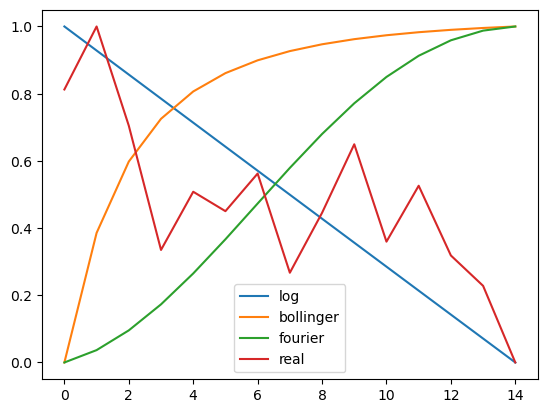

In [8]:
x = range(len(real_data))

plt.plot(x, forecast_log_data, label='log')
plt.plot(x, forecast_bb_data, label='bollinger')
plt.plot(x, forecast_fourier_data, label='fourier')
plt.plot(x, real_data, label='real')

plt.legend()
plt.show()

In [9]:
def forecast_momentum_reversion(data, steps=15, momentum_decay_rate=3, mean_reversion_factor=0.4, noise_scale=0.05):
    last = data[-1]
    if len(data) >= 4:
        momentum = np.mean(np.diff(data[-4:]))
    else:
        momentum = data[-1] - data[-2]
    target = np.mean(data[-10:]) if len(data) >= 10 else np.mean(data)
    forecast = []
    for i in range(steps):
        decay = np.exp(-i / momentum_decay_rate)
        mean_pull = (target - last) * (i / steps) * mean_reversion_factor
        noise = np.random.normal(0, noise_scale)
        next_val = last + momentum * decay + mean_pull + noise
        forecast.append(next_val)
        last = next_val
    return forecast


forecast_momentum_reversion_data = normalize(forecast_momentum_reversion(data_list[:50]))
print(forecast_momentum_reversion_data)

[0.08227729 0.01269951 0.         0.03565455 0.10967344 0.21111334
 0.32880933 0.45227705 0.57256581 0.68280465 0.77851636 0.85755179
 0.91976732 0.96649922 1.        ]


In [15]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')


def forecast_trend_noise(data, steps=15, window=8, noise_scale=0.3, freq=4, phase=6.283185307179586, smooth_window=3):
    x = np.arange(window)
    y = data[-window:]
    weights = np.exp(np.linspace(0, 1, window))
    coeffs = np.polyfit(x, y, 3, w=weights)
    trend = np.polyval(coeffs, np.arange(window, window + steps))
    fitted = np.polyval(coeffs, x)
    residuals = y - fitted
    rolling_std = np.std(data[-window:])
    noise_std = np.std(residuals) * (1 + rolling_std)
    
    # Local noise scale from residual magnitude (interpolated)
    local_noise_scale = np.interp(
        np.arange(steps), 
        np.linspace(0, steps-1, len(residuals)), 
        np.abs(residuals)
    )
    
    noise = noise_std * noise_scale * local_noise_scale * np.sin(np.arange(steps) * freq + phase)
    
    # Blend trend and noisy signal more smoothly
    forecast = trend * (1 - noise_scale) + (trend + noise) * noise_scale
    
    forecast = np.maximum(forecast, 0)
    
    if smooth_window > 1:
        forecast = moving_average(forecast, window_size=smooth_window)
    
    return forecast.tolist()


forecast_trend_noise_data = normalize(forecast_trend_noise(data_list[0:50]))
print(forecast_trend_noise_data)


[0.00168057 1.         0.99831943 0.99831943 0.        ]


ValueError: x and y must have same first dimension, but have shapes (15,) and (5,)

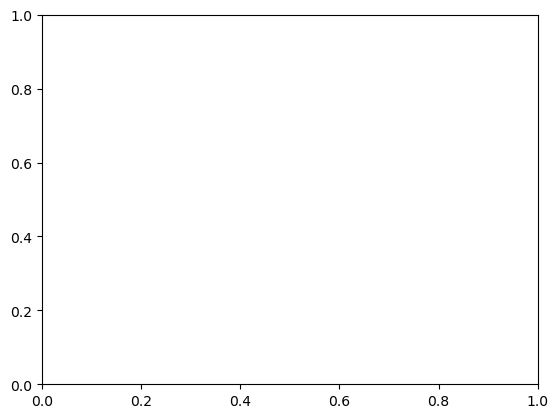

In [16]:
x = range(len(real_data))

plt.plot(x, forecast_trend_noise_data, label='trend_noise')
# plt.plot(x, forecast_momentum_reversion_data, label='momentum_reversion')
plt.plot(x, real_data, label='real')

plt.legend()
plt.show()

In [10]:
import numpy as np

def mse(a, b):
    return np.mean((np.array(a) - np.array(b))**2)

def tune_forecast(data, real, steps=15, window=10):
    best_params = None
    best_error = float('inf')

    freqs = np.linspace(3, 10, 8)          
    phases = np.linspace(0, 2*np.pi, 8)   
    noise_scales = np.linspace(0.3, 1.0, 8) 
    smooth_windows = [1, 2, 3]         
    
    for freq in freqs:
        for phase in phases:
            for noise_scale in noise_scales:
                for smooth_window in smooth_windows:
                    forecast = forecast_trend_noise(
                        data, steps=steps, window=window, 
                        noise_scale=noise_scale, freq=freq, 
                        phase=phase, smooth_window=smooth_window
                    )
                    error = mse(forecast, real)
                    if error < best_error:
                        best_error = error
                        best_params = (freq, phase, noise_scale, smooth_window)
    
    return best_params, best_error

best_params, best_error = tune_forecast(data_list[0:100], real_data, steps=15, window=5)
print(f"Best params (freq, phase, noise_scale, smooth_window): {best_params}")
print(f"Best MSE: {best_error}")


Best params (freq, phase, noise_scale, smooth_window): (np.float64(6.0), np.float64(6.283185307179586), np.float64(0.3), 3)
Best MSE: 512373328006152.56
